# Introduction

Connect Four is a game where two players alternate turns dropping colored discs into a vertical grid. Each player uses a different color (usually red or yellow), and the objective of the game is to be the first player to get four discs in a row.



### 1) A smarter agent

We can improve the performance without devising a complicated strategy, simply by selecting a winning move, if one is available.

Lets provide some helper functions

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym import spaces

!pip install kaggle_environments
from kaggle_environments import evaluate, make

import torch as th
import torch.nn as nn

!pip install stable-baselines3
from stable_baselines3 import PPO 
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [44]:
# Gets board at next step if agent drops piece in selected column
def drop_piece(grid, col, piece, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = piece
    return next_grid

# Returns True if dropping piece in column results in game win
def check_winning_move(obs, config, col, piece):
    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    next_grid = drop_piece(grid, col, piece, config)
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(next_grid[row,col:col+config.inarow])
            if window.count(piece) == config.inarow:
                return True
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(next_grid[row:row+config.inarow,col])
            if window.count(piece) == config.inarow:
                return True
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(next_grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if window.count(piece) == config.inarow:
                return True
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(next_grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if window.count(piece) == config.inarow:
                return True
    return False

def get_win_percentages(agent1, agent2, n_rounds=100):
    # default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print(f'Agent 1 Win Percentage: {np.round(outcomes.count([1,-1])/len(outcomes), 2)}')
    print(f'Agent 2 Win Percentage: {np.round(outcomes.count([-1,1])/len(outcomes), 2)}')

The `check_winning_move()` function takes four required arguments:
- 'col' is any valid move 
- 'piece' is either the agent's mark or the mark of its opponent
- 'obs' contains two pieces of information:
    obs.board - the game board (list that shows the locations of the discs),
    obs.mark - the piece assigned to the agent (either 1 or 2)
- 'config' contains three pieces of information:
    config.columns - number of columns in the game board (7 for ours),
    config.rows - number of rows in the game board (6 for ours),
    config.inarow - number of pieces a player needs to get in a row in order to win (4 for ours)

The function returns `True` if dropping the piece in the provided column wins the game (for either the agent or its opponent), and otherwise returns `False`. 

In [45]:
def agent_q1(obs, config):
    '''
    selects the winning move, if it is available
    otherwise, it should select a random move
    '''
    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]
    piece = obs.mark
    for col in valid_moves:
        if check_winning_move(obs, config, col, piece):
            return col
    return random.choice(valid_moves)

### 2) An even smarter agent

We created an agent that selects winning moves. Now we'll amend the code to create an agent that can also block its opponent from winning 

In [46]:
def agent_q2(obs, config):
    '''
    Select a winning move, if one is available
    Otherwise, it selects a move to block the opponent from winning, if the opponent has a move that it 
    can play in its next turn to win the game. 
    If neither the agent nor the opponent can win in their next moves, the agent selects a random move.
    '''
    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]
    for col in valid_moves:
        if check_winning_move(obs, config, col, obs.mark):
            return col
    for col in valid_moves:
        if check_winning_move(obs, config, col, obs.mark%2+1):
            return col
    return random.choice(valid_moves)

### 3) Create a first agent

In [47]:
def first_agent(obs, config):
    
    def drop_piece(grid, col, piece, config):
        '''
        Returns the grid that results when the player drops its disc in the selected colu
        '''
        next_grid = grid.copy()
        for row in range(config.rows-1, -1, -1):
            if next_grid[row][col] == 0:
                break
        next_grid[row][col] = piece
        return next_grid

    # Returns True if dropping piece in column results in game win
    def check_winning_move(obs, config, col, piece):
        # Convert the board to a 2D grid
        grid = np.asarray(obs.board).reshape(config.rows, config.columns)
        next_grid = drop_piece(grid, col, piece, config)
        # horizontal
        for row in range(config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(next_grid[row,col:col+config.inarow])
                if window.count(piece) == config.inarow:
                    return True
        # vertical
        for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns):
                window = list(next_grid[row:row+config.inarow,col])
                if window.count(piece) == config.inarow:
                    return True
        # positive diagonal
        for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns-(config.inarow-1)):
                window = list(next_grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                if window.count(piece) == config.inarow:
                    return True
        # negative diagonal
        for row in range(config.inarow-1, config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(next_grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                if window.count(piece) == config.inarow:
                    return True
        return False
    
    valid_moves = [col for col in range(config.columns) if obs.board[col]==0]
    piece = obs.mark
    if piece == 1:
        opp_piece = 2
    else:
        opp_piece = 1
    
    for move in valid_moves:
        if check_winning_move(obs, config, move, piece):
            return move
    for move in valid_moves:
        if check_winning_move(obs, config, move, opp_piece):
            return move
    
    return random.choice(valid_moves)

Run the next code cell to watch the agent play a game against the random agent.  You can re-run the code cell to play again!

In [48]:
env = make("connectx", debug=True)
env.run([first_agent, "random"])
env.render(mode="ipython")
get_win_percentages(agent1=first_agent, agent2='random', n_rounds = 50)

Agent 1 Win Percentage: 0.96
Agent 2 Win Percentage: 0.04


# One-Step Lookahead 

### 1) Heuristic

For each potential move we have to predict what out opponent is likely to do in response, along with how we'd then respond, and what the opponent is likely to do then, and so on. Then, you choose the move that you think is most likely to result in a win.

We can formalize this idea and represent all possible outcomes in a (complete) game tree. The complete game tree for Connect Four has over 4 trillion different boards. So in practice, our agent only works with a small subset when planning a move.

To make sure the incomplete tree is still useful to the agent, we will use a heuristic. The heuristic assigns scores to different game boards, where we estimate that boards with higher scores are more likely to result in the agent winning the game.

And how exactly will the agent use the heuristic? Consider it's the agent's turn, and it's trying to plan a move for the game board shown at the top of the figure below. There are seven possible moves (one for each column). For each move, we record the resulting game board. 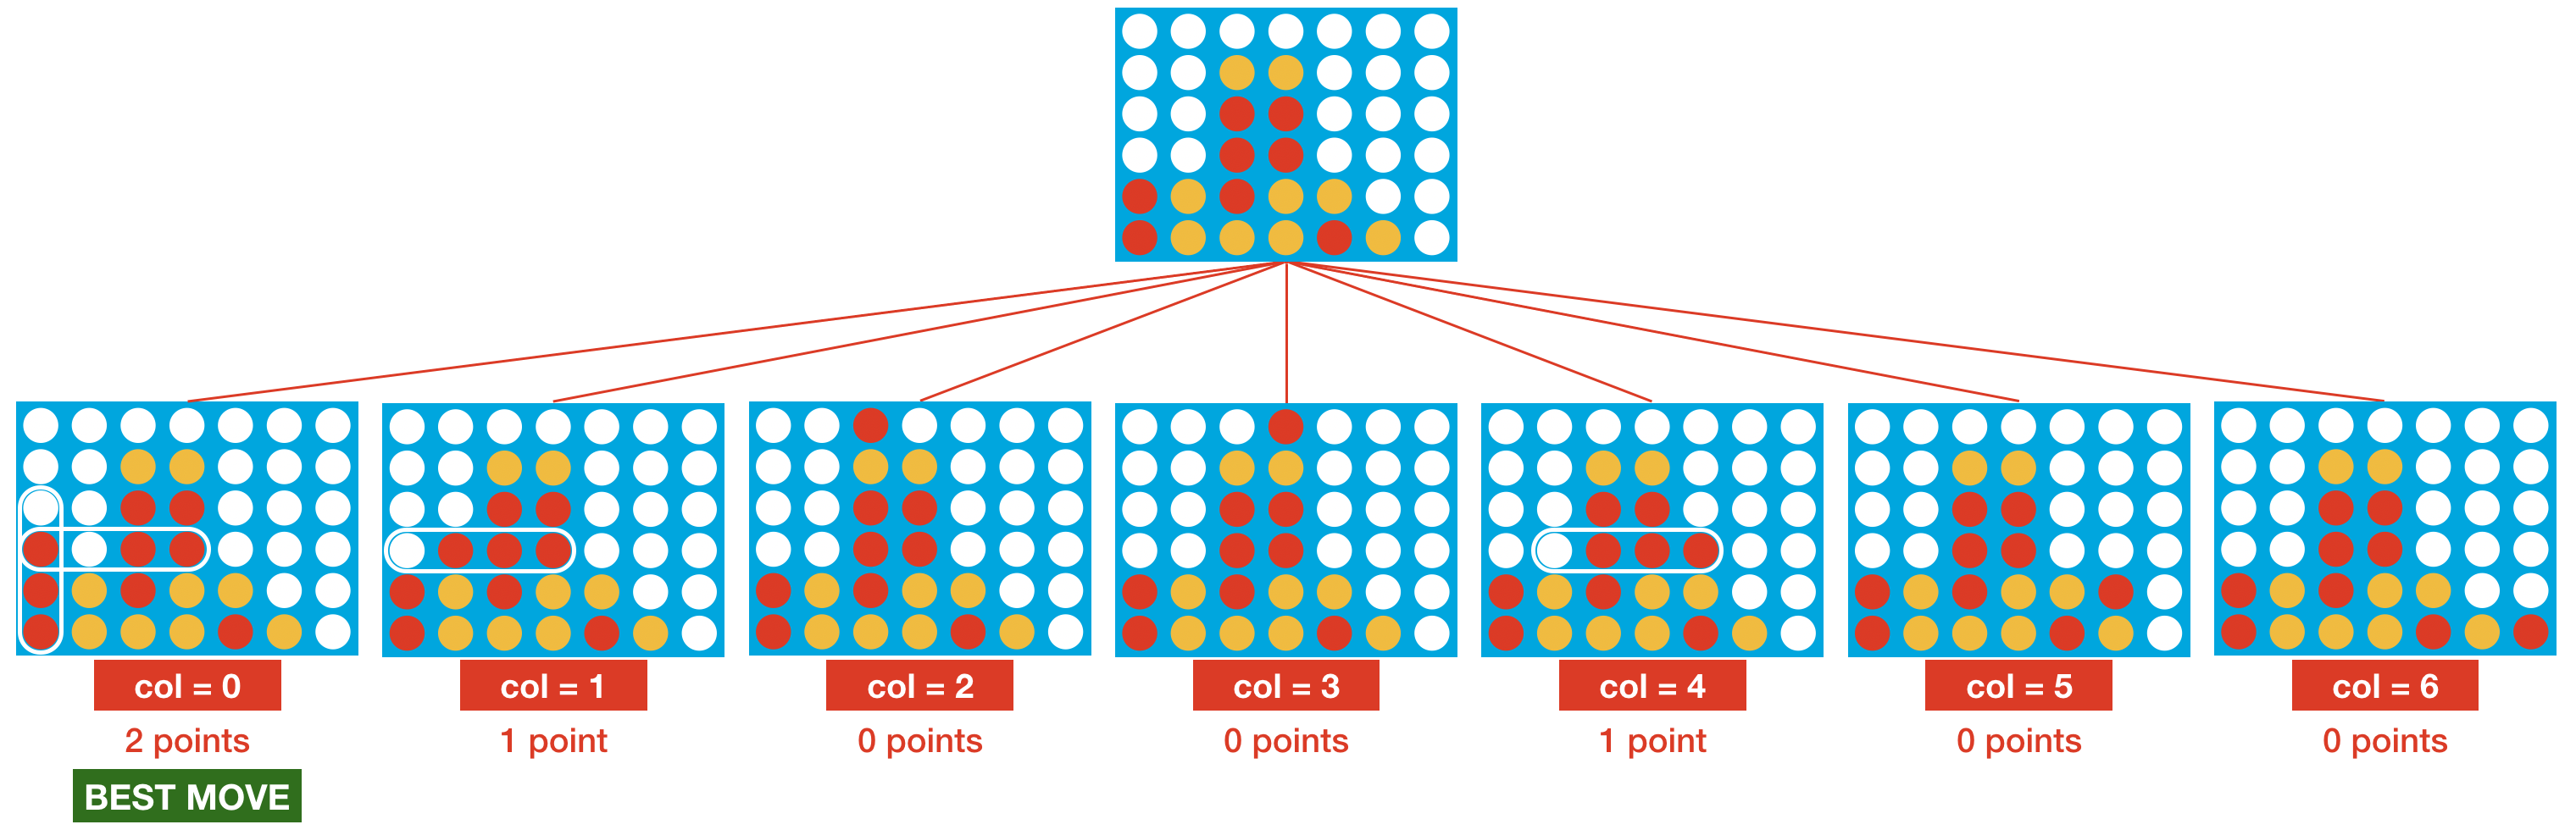

Then we use the heuristic to assign a score to each board. To do this, we search the grid and look for all occurrences of the pattern in the heuristic, similar to a word search puzzle and each occurrence modifies the score


### 2) Second agent

In [49]:
def second_agent(obs, config):

    def score_move(grid, col, mark, config):
        '''
        Calculates the value of the heuristic for each valid move
        '''
        next_grid = drop_piece(grid, col, mark, config)
        score = get_heuristic(next_grid, mark, config)
        return score

    def drop_piece(grid, col, mark, config):
        '''
        Returns the grid that results when the player drops its disc in the selected colu
        '''
        next_grid = grid.copy()
        for row in range(config.rows-1, -1, -1):
            if next_grid[row][col] == 0:
                break
        next_grid[row][col] = mark
        return next_grid

    def get_heuristic(grid, mark, config):
        '''
        Calculates the value of the heuristic for the supplied board (grid), where mark is the mark of the agent.
        '''
        num_threes = count_windows(grid, 3, mark, config)
        num_fours = count_windows(grid, 4, mark, config)
        num_threes_opp = count_windows(grid, 3, mark%2+1, config)
        score = num_threes - 1e2*num_threes_opp + 1e6*num_fours
        return score

    # Helper function for get_heuristic: checks if window satisfies heuristic conditions
    def check_window(window, num_discs, piece, config):
        return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)

    # Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
    def count_windows(grid, num_discs, piece, config):
        '''
        Counts the number of windows (of four adjacent locations in a row, column, or diagonal) 
        that satisfy specific conditions from the heuristic. Specifically, yields the number 
        of windows in the game board (grid) that contain num_discs pieces from the player 
        (agent or opponent) with mark piece, and where the remaining locations in the window are empty
        '''
        num_windows = 0
        # horizontal
        for row in range(config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[row, col:col+config.inarow])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # vertical
        for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns):
                window = list(grid[row:row+config.inarow, col])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # positive diagonal
        for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        # negative diagonal
        for row in range(config.inarow-1, config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                if check_window(window, num_discs, piece, config):
                    num_windows += 1
        return num_windows
    
    # Get list of valid moves
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    
    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    
    # Use the heuristic to assign a score to each possible board in the next turn
    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, config) for col in valid_moves]))
    
    # Get a list of columns (moves) that maximize the heuristic
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    
    # Select at random from the maximizing columns
    return random.choice(max_cols)

Let's see how our first agent plays against the second

In [50]:
env = make("connectx", debug=True)
env.run([second_agent, "random"])
env.render(mode="ipython")
get_win_percentages(agent1=first_agent, agent2=second_agent, n_rounds = 50)

Agent 1 Win Percentage: 0.2
Agent 2 Win Percentage: 0.8


# Minimax Algorithm

Agent doesn't know many things, because it can only look one move into the future. So lets use the minimax algorithm to help the agent look farther into the future and make better-informed decisions.


### Create a minimax agent

In [51]:
N_STEPS = 3

def third_agent(obs, config):

  # Gets board at next step if agent drops piece in selected column
  def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

  # Helper function for get_heuristic: checks if window satisfies heuristic conditions
  def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)
    
  # Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
  def count_windows(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

  # Helper function for minimax: calculates value of heuristic for grid
  def get_heuristic(grid, mark, config):
    num_threes = count_windows(grid, 3, mark, config)
    num_fours = count_windows(grid, 4, mark, config)
    num_threes_opp = count_windows(grid, 3, mark%2+1, config)
    num_fours_opp = count_windows(grid, 4, mark%2+1, config)
    score = num_threes - 1e2*num_threes_opp - 1e4*num_fours_opp + 1e6*num_fours
    return score

  def score_move(grid, col, mark, config, nsteps):
    next_grid = drop_piece(grid, col, mark, config)
    score = minimax(next_grid, nsteps-1, False, mark, config)
    return score

  # Helper function for minimax: checks if agent or opponent has four in a row in the window
  def is_terminal_window(window, config):
    return window.count(1) == config.inarow or window.count(2) == config.inarow

  # Helper function for minimax: checks if game has ended
  def is_terminal_node(grid, config):
    # Check for draw 
    if list(grid[0, :]).count(0) == 0:
        return True

    # Check for win: horizontal, vertical, or diagonal

    # horizontal 
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if is_terminal_window(window, config):
                return True
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if is_terminal_window(window, config):
                return True
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    return False

  # Minimax implementation
  def minimax(node, depth, maximizingPlayer, mark, config):
    is_terminal = is_terminal_node(node, config)
    valid_moves = [c for c in range(config.columns) if node[0][c] == 0]
    if depth == 0 or is_terminal:
        return get_heuristic(node, mark, config)
    if maximizingPlayer:
        value = -np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark, config)
            value = max(value, minimax(child, depth-1, False, mark, config))
        return value
    else:
        value = np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark%2+1, config)
            value = min(value, minimax(child, depth-1, True, mark, config))
        return value
  # Get list of valid moves
  valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
  # Convert the board to a 2D grid
  grid = np.asarray(obs.board).reshape(config.rows, config.columns)
  # Use the heuristic to assign a score to each possible board in the next step
  scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, config, N_STEPS) for col in valid_moves]))
  # Get a list of columns (moves) that maximize the heuristic
  max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
  # Select at random from the maximizing columns
  return random.choice(max_cols)

Let's see how our new agent plays against the second one

In [52]:
env = make("connectx", debug=True)
env.run([third_agent, second_agent])
env.render(mode="ipython")
get_win_percentages(agent1=third_agent, agent2=second_agent, n_rounds=10)

Agent 1 Win Percentage: 0.8
Agent 2 Win Percentage: 0.2


# Reinforcment Learning

Our goal is to find the weights of the neural network that (on average) maximize the agent's cumulative reward.

Initially, the weights are set to random values.
As the agent plays the game, the algorithm continually tries out new values for the weights, to see how the cumulative reward is affected, on average. Over time, after playing many games, we get a good idea of how the weights affect cumulative reward, and the algorithm settles towards weights that performed better.


### 1) Setup

There's a bit of extra work that we need to do to make the environment compatible with Stable Baselines. For this, we define the ConnectFourGym class below. This class implements ConnectX as an OpenAI Gym environment and uses several methods:

- reset() will be called at the beginning of every game. It returns the starting game board as a 2D numpy array with 6 rows and 7 columns.
change_reward() customizes the rewards that the agent receives. 
- step() is used to play the agent's choice of action (supplied as action), along with the opponent's response. It returns: the resulting game board (as a numpy array), the agent's reward (from the most recent move only: one of +1, -10, -1, or 1/42), and whether or not the game has ended (if the game has ended, done=True; otherwise, done=False).

In [53]:
class ConnectFourGym(gym.Env):
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(1,self.rows,self.columns), dtype=int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns), reward, done, _

In [60]:
env = ConnectFourGym(agent2="random")

### 2) Architecture of the Neural Network

In [ ]:
class CustomCNN(BaseFeaturesExtractor):
    
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int=128):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # CxHxW images (channels first)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
)
        
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=0)

In [ ]:
model.learn(total_timesteps=60000)

In [64]:
def fourth_agent(obs, config):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(1, 6,7))
    is_valid = (obs['board'][int(col)] == 0)
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [66]:
env = make("connectx")

env.run([third_agent, fourth_agent])

env.render(mode="ipython")
get_win_percentages(agent1=third_agent, agent2=fourth_agent, n_rounds=10)

Agent 1 Win Percentage: 1.0
Agent 2 Win Percentage: 0.0
